In [1]:
cd "C:\Users\toni3\Documents\Universidad\Master\4\Smart Society\Lab 1"

C:\Users\toni3\Documents\Universidad\Master\4\Smart Society\Lab 1


In [2]:
import scipy.io
mat = scipy.io.loadmat('HAR_database.mat')

## 1. Initial analysis

### Size of each continous sequence

It may be useful to measure which is the size of each sequence of samples with the same label (for instace for giving some tentative values for the window size). As an example, if the labels are:

[3 3 3 3 4 4 4 4 4 2 2 2 3...]

For that example, the sizes of the sequences are [4,5,3,...]

We will combine the data from the 8 training data persons:

In [3]:
import numpy as np
from scipy import stats

train = mat['database_training']
a = train[:,1][1][0]
count = 0
len_seq = []

for j in range(8):
    a = train[:,1][j][0]
    len_temp = 0
    for i in range(len(a)-1):  
        if a[i+1] != a[i] or i == len(a) - 2:
            count += 1
            len_seq.append(len_temp)
            len_temp = 0
        else:
            len_temp += 1

len_seq.sort() # for a better visualization of the minimux and maximum values
print("Number of total sequences: " + str(count))
print("List of sizes of sequences: " + str(len_seq))
print("Average value of size: " + str(np.mean(len_seq)))
print("Median value of size: " + str(np.median(len_seq)))

Number of total sequences: 160
List of sizes of sequences: [126, 127, 145, 160, 163, 163, 182, 208, 211, 221, 224, 235, 248, 252, 276, 281, 335, 346, 378, 385, 401, 401, 423, 440, 458, 499, 511, 513, 523, 526, 561, 568, 576, 591, 595, 596, 606, 607, 609, 615, 615, 638, 666, 669, 672, 673, 674, 685, 685, 689, 698, 703, 707, 719, 733, 753, 769, 770, 770, 770, 773, 784, 792, 796, 809, 815, 823, 835, 837, 840, 845, 861, 865, 875, 877, 882, 888, 892, 912, 926, 937, 940, 955, 957, 958, 959, 975, 980, 981, 982, 983, 984, 985, 988, 995, 1008, 1016, 1020, 1026, 1034, 1054, 1075, 1076, 1086, 1089, 1095, 1095, 1100, 1100, 1102, 1106, 1108, 1112, 1115, 1118, 1118, 1118, 1122, 1132, 1147, 1160, 1162, 1164, 1165, 1168, 1175, 1176, 1182, 1190, 1201, 1204, 1215, 1217, 1218, 1225, 1236, 1276, 1305, 1305, 1309, 1317, 1324, 1337, 1345, 1365, 1371, 1385, 1390, 1398, 1442, 1447, 1458, 1473, 1473, 1483, 1534, 1551, 1553, 1635, 1723]
Average value of size: 882.8625
Median value of size: 931.5


As the minimum size of a sequence is 126, it makes sense that the maximum length of the window is 126/2 = 63. Therefore, as the sampling frequency is 16Hz, we can try for instance these values for the length of the window L: 16, 32, 48, 62. (with L = 64 we can risk that a window is incorrectly labeled).

### Strategy for the analysis

Trying to create a window for each individual sample will require a lot of time for processing the data, training the model and adjusting the hyperparameters. For that reason, the data will based on the windows.

Let's first define a transformation as the process of converting 1 vector of data of a signal into 1 value. As there are 5 signals of input data, if we make a number of $t$ transformations for each signal, the total number of inputs for each window will be $5t$. (for instance, for 7 transformation we would have 35 inputs).

That means that we will convert all the data from the 8 persons into a number N of instances of dimension 5t. If the total number of samples for a person is $S$ and the length of the window is $L$, the number of instances N will be $S/L$ (for example, if a person has 18000 instances and L=48, there will be 375 instances of that person in the training set).

To finally clarify the strategy, let's make an example. Imagine the original dataset is the following (the symbol '|' splits the different windows, which in this case is L = 3 for simplicity):

----------------

Person 1, 1st signal:  1.2, 1.4, 1,2 | 1.3, 1.5, 1.8 | ........ ( 3000 windows in total for Person 1)

Person 1, 2nd signal:  0.3, 0.1, 0.8, | ........

Person 1, 3rd signal:  9.2, ... | ... | .......

Person 1, 4th signal:  1.2, ... | ... | .......

Person 1, 5th signal:  8.1, ... | ... | .......


Person 2, 1st signal: 1.1, 1.7, 1.6 | ......     ( 2500 windows in total for Person 2)

Person 2, 2nd signal:  ...

Person 2, 3rd signal:  ...

Person 2, 4th signal:  ...

Person 2, 5th signal:  ...

Person 3, 1st signal:  ...

        ...
        
----------------

Then, if we have for instance **two tranformations** (mean and median), the train set would be (just the **X matrix**):


-----------------

instance **0**: [ mean_Person1_1stWindow_1stSignal, mean_Person1_1stWindow_2ndSignal, ..., mean_Person1_1stWindow_5thSignal, median_Person1_1stWindow_1stSignal, ..., median_Person1_1stWindow_5thSignal ]

instance **1**: [ mean_Person1_2ndWindow_1stSignal, mean_Person1_2ndWindow_2ndSignal, ..., mean_Person1_2ndWindow_5thSignal, median_Person1_2ndWindow_1stSignal, ..., median_Person1_2ndWindow_5thSignal ]

...

instance **2999**: [ mean_Person1_3000thWindow_1stSignal, mean_Person1_3000thWindow_2ndSignal, ..., mean_Person1_3000thWindow_5thSignal, median_Person1_3000thWindow_1stSignal, ..., median_Person1_3000thWindow_5thSignal ]

instance **3000**: [ mean_Person2_1stWindow_1stSignal, mean_Person2_1stWindow_2ndSignal, ..., mean_Person2_1stWindow_5thSignal, median_Person2_1stWindow_1stSignal, ..., median_Person2_1stWindow_5thSignal ]

...

instance **5449**: [ mean_Person2_2500thWindow_1stSignal, mean_Person2_2500thWindow_2ndSignal, ..., mean_Person2_2500thWindow_5thSignal, median_Person2_2500thWindow_1stSignal, ..., median_Person2_2500thWindow_5thSignal ]

instance **5500**: [ mean_Person3_1stWindow_1stSignal, mean_Person3_1stWindow_2ndSignal, ..., mean_Person3_1stWindow_5thSignal, median_Person3_1stWindow_1stSignal, ..., median_Person3_1stWindow_5thSignal ]

...
...

----------------

Clearly, for the **Y vector** (output), the label for each instance will be **mode** of all the labels of the window.


## 2. Preprocessing

### 2.1 Segmentation and Feature extraction (only from extract Time-domain features).

In [ ]:
#!pip install librosa
#!pip install entropy
#import librosa
#import entropy

In [4]:
train = mat['database_training']
test = mat['database_test']

# X = train[:,0]
# y = train[:,1]

n_persons = train[:,0].shape[0]

X_train = []
y_train = []

L = 48 # length of the window (HYPERPARAMETER!!)

for person in range(n_persons):
    X_person = train[:,0][person]
    y_person = train[:,1][person]
    S = X_person.shape[1] # number of samples for this person
    n_w = int(S/L) # number of windows for this person
    for w in range(n_w):
        mat_x = X_person[:,w*L:(w+1)*L] # the complete matrix 5xS of each window: 5 rows (each signal) and S samples
                                       # mat_w is a numpy ndarray
            
        vec_y = y_person[0,w*L:(w+1)*L] # the vector of S elements that corresponds to the labels
        y_train.append(stats.mode(vec_y)[0][0]) # the label of the window (or instance) is the mode value of the window
        
        # Time-domain statistics
        mean_transf = np.mean(mat_x,axis=1)
        #median_transf = np.median(mat_x,axis=1)
        std_transf = np.std(mat_x, axis=1)
        rms_transf = np.sqrt(np.mean(np.square(mat_x), axis=1))
        amp_transf = np.max(mat_x, axis=1) - np.min(mat_x, axis=1)
        
        derivative_mat_x = np.array(np.gradient(mat_x, axis=1))
        n_preaks_transf = np.sum((derivative_mat_x < 0.00001), axis=1)
        
        # Frequency-domain statistics (TODO)
        #fft = np.fft.fft(mat_x)
        #sp_centroid = librosa.feature.spectral_centroid(mat_x, sr=16, axis=1)
        #sp_entropy = entropy.spectral_entropy(X_person[0, 100:148], sr=16, axis=1)
        
        # ADD HERE MORE TRANSFORMATION, the output must be a numpy vector of 5 elements
        
        
        final_vector = np.array([mean_transf, std_transf, rms_transf,
                                amp_transf, n_preaks_transf]) # final vector with all the values for each window (or instance)
        # INSERT THE REST OF TRANSFORMATIONS HERE TO PUT THEM ALL TOGETHER IN A SINGLE VECTOR
        final_vector_list = final_vector.flatten().tolist()
        X_train.append(final_vector_list)       

X_train = np.array(X_train)
y_train = np.array(y_train)

In [5]:
print(X_train.shape)
print(y_train.shape)

(2943, 25)
(2943,)


We now have an X_train and y_train sets (THE DIFFICULT PART IS DONE!!) so we can now make the usual process of Machine Learning

###  2.2 Feature Selection

Choose the best variables (columns of X_train), as we have $5t$ different features.

In [6]:
from sklearn.feature_selection import f_classif, mutual_info_classif
import pandas as pd
np.random.seed(0)

f_score = f_classif(X_train, y_train) # The ones with highest F-score are the most related with the output class
m_i = mutual_info_classif(X_train,y_train) # highest score are the most relevant features

df = pd.DataFrame({'F-score':np.round(f_score[0]/1000, 2), 'Mutual-info':np.round(m_i, 2)})
print(df)

    F-score  Mutual-info
0      5.96         1.00
1      5.26         1.10
2      0.00         0.23
3      0.00         0.26
4      0.00         0.29
5      3.09         0.59
6      1.18         0.58
7      2.91         0.60
8      1.86         0.59
9      1.15         0.65
10     4.24         1.07
11     4.19         1.13
12     2.63         0.63
13     1.67         0.63
14     1.02         0.60
15     2.53         0.59
16     1.24         0.58
17     2.28         0.57
18     1.28         0.57
19     0.90         0.65
20     0.05         0.03
21     0.04         0.05
22     0.00         0.01
23     0.00         0.00
24     0.03         0.02


In [7]:
from sklearn.feature_selection import SelectKBest
set1 = SelectKBest(f_classif, k = 20)
set1.fit(X_train, y_train)
mask1 = set1.get_support()
print(mask1)

set2 = SelectKBest(mutual_info_classif, k = 20)
set2.fit(X_train, y_train)
mask2 = set2.get_support()
print(mask2)

mask3 = mask1 & mask2
print(mask3)

X_first_filter = X_train[:, mask3]
print(X_first_filter.shape)

[ True  True False False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True False False
  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False]
[ True  True False False False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False False False False
 False]
(2943, 17)


## 3. Model training

We are going to use XGBoost. XGBoost is a GBM implementation with regularization, which helps reducing overfitting if we are able to fine-tune its hyper-parameters. 

Its parameters are the following: 

Parameters: 
+ objective: loss function to minimize. Usually: binary:logistic, multi:softmax and multi:softprob (returns probabilities instead of the class).
+ num_class: number of classes. Need to specify is multi:softmax objective function.
+ colsample_bytree: percentage of features used per tree. High value can lead to overfitting. Low value makes it slower to train. Typically use 0.5-1.
+ subsample: percentage of samples used per tree. Low value can lead to underfitting. High value makes it slower to train. Typically use 0.5-1.
+ learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]. Typically use 0.01-0.2.
+ max_depth: Typically, 3-10.
+ n_estimators.
+ eval_metric: metric for validation data. Ex: rmse, error (for binary), merror (for multiclass), aux, logloss, mlogloss, etc. https://xgboost.readthedocs.io/en/latest/parameter.html
+ seed.

Regularization parameters: 
+ alpha: L1 regularization (lasso) on leaf weights. A large value leads to more regularization.
+ beta: L2 regularization (ridge) on leaf weights. A large value leads to more regularization. We usually go for alpha and forget about beta. 
+ gamma: A node is split only when the resulting split gives a positive reduction in the loss function. Gamma specifies the minimum loss reduction required to make a split. It makes the algorithm conservative.

In [8]:
import xgboost as xgb

XGBoost library has an optimized data structure called Dmatrix and we can use it in the native methods of XGBoost (.cv and .train).

In [9]:
y_train = y_train - 1 # Need to include label 0
data_dmatrix = xgb.DMatrix(data=X_first_filter, label=y_train)

### 3.1 Fit one classifier

In [10]:
# Fit one classifier 
xg_class = xgb.XGBClassifier(objective ='multi:softmax', num_class = 5,colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
xg_class.fit(X_train,y_train)

XGBClassifier(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, num_class=5, objective='multi:softprob',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1)

### 3.2 Training with CV.

To get a more accurate performance, we should use CV when fitting the classifier.

In [11]:
# Training with cross-validation
params = {"objective":'multi:softmax','num_class':5,'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="merror", as_pandas=True, seed=123)


In [12]:
cv_results.head(5)

,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
0,0.036188,0.004690,0.046891,0.002497
1,0.037037,0.006316,0.047231,0.002543
2,0.032790,0.003011,0.042134,0.004584
3,0.032790,0.004859,0.043493,0.004584
4,0.035848,0.007448,0.045532,0.002095


In the cv_results object we have stored the metrics averaged along the CV for the different number of trees. See how as the number of trees increases, the test error decreases.

### 3.3 Hyper-parameter tuning

To actually get the most out of XGBoost, we should optimize its hyper-parameters carefully.

The general approach is: 

1. Choose a relatively **high learning rate**. Generally a learning rate of **0.1 works** but somewhere between 0.05 to 0.3 should work for different problems. **Determine the optimum number of trees for this learning rate** (using XGBoost cv).

2. **Tune tree-specific parameters** (max_depth, min_child_weight, gamma, subsample, colsample_bytree) **for decided learning rate and number of trees.** Note that we can choose different parameters to define a tree.

3. **Tune regularization parameters** (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.

4. **Lower the learning rate and decide the optimal parameters.**

##### 3.3.1 Fix learning rate and find n_estimators.

Start with some initial tree-based parameters (will be optimized in the next step). 

In [13]:
from sklearn import metrics
import matplotlib.pyplot as plt
def modelfit(alg, X_train, y_train, useTrainCV=True, cv_folds=10, early_stopping_rounds=50):
    # FUNCTION TO DETERMINE THE PERFECT NUMBER OF ESTIMATORS AUTOMATICALLY AND GIVE METRICS OF THIS 
    # X_train: numpy array
	# y_train: numpy array
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(data=X_train, label=y_train)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics='merror', early_stopping_rounds=early_stopping_rounds, as_pandas=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    print(cvresult.tail())
    #Fit the algorithm on the data
    alg.fit(X_train, y_train,eval_metric='merror')
        
    #Predict training set:
    train_predictions = alg.predict(X_train)
    train_predprob = alg.predict_proba(X_train)[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Micro F1 score : %.4g" % metrics.f1_score(y_train, train_predictions, average='micro'))
    print("Macro F1 score : %.4g" % metrics.f1_score(y_train, train_predictions, average='macro'))
    print("Balanced accuracy : %.4g" % metrics.balanced_accuracy_score(y_train, train_predictions))
    print("Optimum number of trees: %s" % alg.get_xgb_params()['n_estimators'])
    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return alg

    train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
37           0.003398          0.000716          0.018688         0.006672
38           0.003360          0.000663          0.019027         0.006831
39           0.003285          0.000535          0.019027         0.006831
40           0.003134          0.000448          0.019027         0.006831
41           0.003134          0.000610          0.018347         0.007320

Model Report
Micro F1 score : 0.9973
Macro F1 score : 0.9969
Balanced accuracy : 0.9959
Optimum number of trees: 42


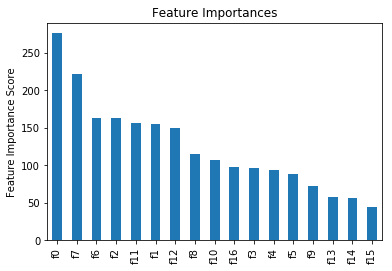

In [14]:
xgb1 = xgb.XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000, # set a high number, but the custom modelfit function will stop at the right place
    max_depth=5,
    min_child_weight=1,
    gamma=0.2,
    alpha=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='multi:softmax',
    num_class=5,
    nthread=4,
    scale_pos_weight=1,
    seed=0)
alg = modelfit(xgb1, X_first_filter, y_train)

**This problem is extremely easy and with almost default parameters we obtain a .98 accuracy. We will continue tuning the hyperparameters just to learn how to do it**.

##### 3.3.2. Tune tree-based parameters:

Start with the most important: **max_depth**.

Then, try **gamma**, **subsambple** and **colsample_bytree**.

In [158]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
param_test1 = {
 'max_depth':range(3,10)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier( learning_rate =0.1, n_estimators=53, max_depth=5,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective='multi:softmax', nthread=4, scale_pos_weight=1, seed=0),
                        param_grid = param_test1, scoring='balanced_accuracy',n_jobs=4,iid=False, cv=5)
gsearch1.fit(X_first_filter,y_train)
print(gsearch1.best_params_, gsearch1.best_score_)

{'max_depth': 4} 0.9465227067344395


We should probably first tune **gamma** alone and then tune **subsample** and **colsample_bytree** together. But we will do everything together because our training set is small. 

In [143]:
param_test2 = {
    'gamma': [i/10.0 for i in range(0,5)],
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch2 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=53, max_depth=4,
                                                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=0),
                        param_grid = param_test2, scoring='balanced_accuracy',n_jobs=4,iid=False, cv=5)
gsearch2.fit(X_first_filter,y_train)
print(gsearch2.best_params_, gsearch2.best_score_)

{'colsample_bytree': 0.6, 'gamma': 0.4, 'subsample': 0.9} 0.952364666261267


We previously iterated in increments of 0.1 around the values. Now, centered in the new values (0.6, 0.4 and 0.9), let's iterate in increments of 0.05 to see if we can improve the performance.

In [147]:
param_test3 = {
    'gamma': [i/100.0 for i in range(30,50,5)],
    'subsample':[i/100.0 for i in range(80,105,5)],
    'colsample_bytree':[i/100.0 for i in range(50,70,5)]
}
gsearch3 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=53, max_depth=4,
                                                  min_child_weight=1, gamma=0.4, subsample=0.9, colsample_bytree=0.6,
                                                  objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=0),
                        param_grid = param_test3, scoring='balanced_accuracy',n_jobs=4,iid=False, cv=5)
gsearch3.fit(X_first_filter,y_train)
print(gsearch3.best_params_, gsearch3.best_score_)

{'colsample_bytree': 0.55, 'gamma': 0.35, 'subsample': 0.8} 0.9527801828946328


We check all the tuned parameters: 

     train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
133           0.000378      5.421011e-20          0.018006         0.005892
134           0.000378      5.421011e-20          0.018006         0.005892
135           0.000378      5.421011e-20          0.018006         0.005892
136           0.000378      5.421011e-20          0.018006         0.005892
137           0.000378      5.421011e-20          0.017667         0.005845

Model Report
Micro F1 score : 0.9997
Macro F1 score : 0.9997
Balanced accuracy : 0.9997
Optimum number of trees: 138


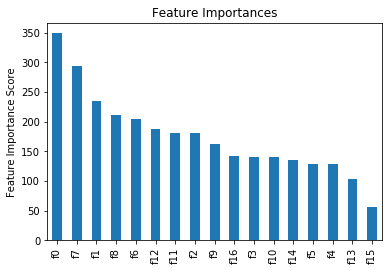

In [15]:
xgb2 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000, # set a high number, but the custom modelfit function will stop at the right place
    max_depth=4,
    min_child_weight=1,
    gamma=0.35,
    alpha=0,
    subsample=0.8,
    colsample_bytree=0.55,
    objective='multi:softmax',
    num_class=5,
    nthread=4,
    scale_pos_weight=1,
    seed=0)
alg2 = modelfit(xgb2, X_first_filter, y_train)

##### 3.3.3. Tune regularization.

We have already tuned **gamma**, but we can also try with **alpha**.

In [161]:
param_test4 = {
    'alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate=0.1, n_estimators=67, max_depth=4,
                                                  min_child_weight=1, gamma=0.35, subsample=0.8, colsample_bytree=0.55,
                                                  objective= 'multi:softmax', nthread=4, scale_pos_weight=1,seed=0),
                        param_grid = param_test4, scoring='balanced_accuracy',n_jobs=4,iid=False, cv=5)
gsearch4.fit(X_first_filter,y_train)
print(gsearch4.best_params_, gsearch4.best_score_)

{'alpha': 1e-05} 0.9517360956751517


Test this new classifier.

     train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
133           0.000378      5.421011e-20          0.018006         0.005892
134           0.000378      5.421011e-20          0.018006         0.005892
135           0.000378      5.421011e-20          0.018006         0.005892
136           0.000378      5.421011e-20          0.018006         0.005892
137           0.000378      5.421011e-20          0.017667         0.005845

Model Report
Micro F1 score : 0.9997
Macro F1 score : 0.9997
Balanced accuracy : 0.9997
Optimum number of trees: 138


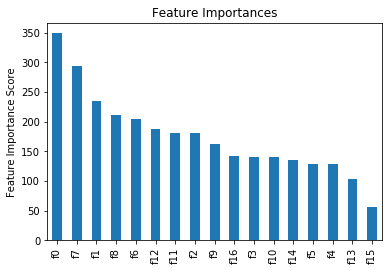

In [16]:
xgb3 = xgb.XGBClassifier(
    learning_rate=0.1,
    n_estimators=1000, # set a high number, but the custom modelfit function will stop at the right place
    max_depth=4,
    min_child_weight=1,
    gamma=0.35,
    alpha=1e-05,
    subsample=0.8,
    colsample_bytree=0.55,
    objective='multi:softmax',
    num_class=5,
    nthread=4,
    scale_pos_weight=1,
    seed=0)
alg3 = modelfit(xgb3, X_first_filter, y_train)

##### 3.3.4 Decrease **learning rate** and increase **n_estimators**.

Lastly, we should lower the learning rate and add more trees.

     train-merror-mean  train-merror-std  test-merror-mean  test-merror-std
251           0.008684          0.000861          0.020726         0.004910
252           0.008608          0.000874          0.020726         0.004910
253           0.008533          0.000864          0.020726         0.004910
254           0.008495          0.000796          0.020726         0.004910
255           0.008495          0.000796          0.020387         0.004562

Model Report
Micro F1 score : 0.9922
Macro F1 score : 0.9899
Balanced accuracy : 0.9884
Optimum number of trees: 256


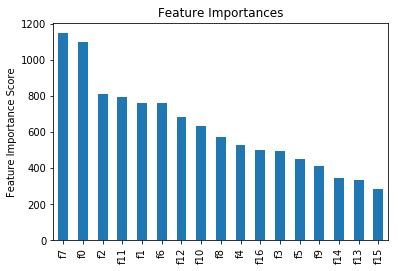

In [17]:
xgb4 = xgb.XGBClassifier(
    learning_rate=0.01,
    n_estimators=1000, # set a high number, but the custom modelfit function will stop at the right place
    max_depth=4,
    min_child_weight=1,
    gamma=0.35,
    alpha=1e-05,
    subsample=0.8,
    colsample_bytree=0.55,
    objective='multi:softmax',
    num_class=5,
    nthread=4,
    scale_pos_weight=1,
    seed=0)
alg4 = modelfit(xgb4, X_first_filter, y_train)

## 4. Predict the test set

Once we have the best model, we predict the test set.

### 4.1 Transform test set

In [203]:
# First transform the X as before (MODIFY THE CODE)
X_test = []
data_end = []
n_persons = test[:,0].shape[0]
for person in range(n_persons):
    X_person = test[:,0][person]
    S = X_person.shape[1] # number of samples for this person
    n_w = int(S/L) # number of windows for this person
    X_person_test = []
    for w in range(n_w):
        mat_x = X_person[:,w*L:(w+1)*L] # the complete matrix 5xS of each window: 5 rows (each signal) and S samples
                                           # mat_w is a numpy ndarray
          
        # Time-domain statistics
        mean_transf = np.mean(mat_x,axis=1)
        #median_transf = np.median(mat_x,axis=1)
        std_transf = np.std(mat_x, axis=1)
        rms_transf = np.sqrt(np.mean(np.square(mat_x), axis=1))
        amp_transf = np.max(mat_x, axis=1) - np.min(mat_x, axis=1)
        
        derivative_mat_x = np.array(np.gradient(mat_x, axis=1))
        n_preaks_transf = np.sum((derivative_mat_x < 0.00001), axis=1)
        
        # Frequency-domain statistics (TODO)
        #fft = np.fft.fft(mat_x)
        #sp_centroid = librosa.feature.spectral_centroid(mat_x, sr=16, axis=1)
        #sp_entropy = entropy.spectral_entropy(X_person[0, 100:148], sr=16, axis=1)
        
        # ADD HERE MORE TRANSFORMATION, the output must be a numpy vector of 5 elements
        
        
        final_vector = np.array([mean_transf, std_transf, rms_transf,
                                amp_transf, n_preaks_transf]) # final vector with all the values for each window (or instance)
        # INSERT THE REST OF TRANSFORMATIONS HERE TO PUT THEM ALL TOGETHER IN A SINGLE VECTOR
        final_vector_list = final_vector.flatten().tolist()
        X_person_test.append(final_vector_list) 
        
    data_end.append(S - L*n_w)
    X_test.append(np.array(X_person_test))

### 4.2 Make predictions

Note that, since we are windowing the signals, there are always some points at the end ignored. We decided to just repeat the last prediction for these last points.

In [217]:
n_persons = test[:,0].shape[0]
pred = []
for person in range(n_persons):
    pred_aux = alg4.predict(X_test[person][:, mask3])
    pred_aux = np.repeat(pred_aux, L)
    pred.append(np.concatenate((pred_aux, np.repeat(pred_aux[-1], data_end[person]))))

In [220]:
scipy.io.savemat('test.mat', dict(x=pred[0], y=pred[1]))